<div align="center">
  <h1><b>Penyisihan Datavidia 9</b></h1>
  <p><b>Supercalifragilisticexpialidocious</b></p>
  <span style="font-size: 12px;">Author: <a href="https://github.com/ChristellaCindy">Christella Cindy</a>, <a href="https://github.com/Frederickkrisna">Frederick Krisna</a>, and <a href="https://github.com/williamtheodoruswijaya">William Theodorus</a></span>
</div>
<hr>

### 1. Import Libraries

In [153]:
import pandas as pd
import tensorflow as tf
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import math
import os
import warnings
warnings.filterwarnings('ignore')
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import Normalizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

color_pal = sns.color_palette()

- `Evaluation`

In [154]:
def mape(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    """
    Calculate the Mean Absolute Percentage Error (MAPE).

    Parameters:
    y_true (array-like): True values.
    y_pred (array-like): Predicted values.

    Returns:
    float: The calculated MAPE.
    """
    return np.mean(np.abs((y_true - y_pred) / y_true))


### 2. Load Dataset
---
untuk training, kita akan coba pakai salah terlebih dahulu yaitu "Bawang Merah"

In [155]:
path = "Harga Bahan Pangan/train"
files = [
    "Bawang Merah", "Bawang Putih Bonggol", "Beras Medium", "Beras Premium",
    "Cabai Merah Keriting", "Cabai Rawit Merah", "Daging Ayam Ras",
    "Daging Sapi Murni", "Gula Konsumsi", "Minyak Goreng Curah",
    "Minyak Goreng Kemasan Sederhana", "Telur Ayam Ras", "Tepung Terigu (Curah)"
]

# Load data
df_list = {}
for file in files:
    df = pd.read_csv(f"Harga Bahan Pangan/train/{file}.csv")
    df['Date'] = pd.to_datetime(df['Date'])
    df = df.set_index('Date')
    df_list[file] = df

# For Training purpose, we use only Bawang Merah since all training have the same approach
df = df_list["Bawang Merah"]
df.head()

,Aceh,Bali,Banten,Bengkulu,DI Yogyakarta,DKI Jakarta,Gorontalo,Jambi,Jawa Barat,Jawa Tengah,...,Papua,Riau,Sulawesi Barat,Sulawesi Selatan,Sulawesi Tengah,Sulawesi Tenggara,Sulawesi Utara,Sumatera Barat,Sumatera Selatan,Sumatera Utara
Date,,,,,,,,,,,,,,,,,,,,,
2022-01-01,28970.0,20870.0,26890.0,26650.0,25240.0,35510.0,31740.0,23390.0,25800.0,24870.0,...,48610.0,29240.0,25160.0,24910.0,28030.0,30380.0,35750.0,23360.0,26670.0,28710.0
2022-01-02,29900.0,20710.0,25600.0,26950.0,25240.0,31850.0,30020.0,23550.0,26010.0,24630.0,...,50160.0,28750.0,24770.0,24360.0,27200.0,30260.0,35630.0,23790.0,25690.0,28460.0
2022-01-03,28970.0,20510.0,26390.0,27290.0,24620.0,34880.0,31250.0,23730.0,25910.0,24810.0,...,49510.0,27870.0,24140.0,24740.0,26750.0,30080.0,34980.0,22620.0,26270.0,28050.0
2022-01-04,29600.0,20180.0,26630.0,27450.0,24370.0,35260.0,31640.0,23300.0,25950.0,24910.0,...,49670.0,28330.0,24450.0,24710.0,28800.0,29950.0,34920.0,23010.0,26800.0,27800.0
2022-01-05,29540.0,19960.0,26610.0,27710.0,24210.0,35260.0,34010.0,23640.0,25700.0,24580.0,...,46590.0,28240.0,24640.0,24780.0,28990.0,30240.0,34000.0,23330.0,25360.0,27670.0


In [156]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1004 entries, 2022-01-01 to 2024-09-30
Data columns (total 34 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Aceh                       967 non-null    float64
 1   Bali                       968 non-null    float64
 2   Banten                     967 non-null    float64
 3   Bengkulu                   967 non-null    float64
 4   DI Yogyakarta              968 non-null    float64
 5   DKI Jakarta                967 non-null    float64
 6   Gorontalo                  969 non-null    float64
 7   Jambi                      966 non-null    float64
 8   Jawa Barat                 967 non-null    float64
 9   Jawa Tengah                970 non-null    float64
 10  Jawa Timur                 969 non-null    float64
 11  Kalimantan Barat           968 non-null    float64
 12  Kalimantan Selatan         967 non-null    float64
 13  Kalimantan Tengah          968

In [157]:
df.describe()

,Aceh,Bali,Banten,Bengkulu,DI Yogyakarta,DKI Jakarta,Gorontalo,Jambi,Jawa Barat,Jawa Tengah,...,Papua,Riau,Sulawesi Barat,Sulawesi Selatan,Sulawesi Tengah,Sulawesi Tenggara,Sulawesi Utara,Sumatera Barat,Sumatera Selatan,Sumatera Utara
count,967.000000,968.000000,967.000000,967.000000,968.000000,967.000000,969.000000,966.000000,967.000000,970.000000,...,967.000000,969.000000,965.000000,970.000000,970.000000,968.000000,970.000000,969.000000,966.000000,968.000000
mean,34740.020683,28202.200413,34011.065150,34812.130300,30753.657025,41475.170631,38127.925697,28944.668737,33151.437435,32025.659794,...,56483.588418,33857.058824,33921.761658,32272.938144,38495.804124,38152.283058,41372.639175,29558.513932,33948.768116,33269.855372
std,7681.229521,6421.992994,7649.079784,7773.763022,7927.974207,8408.909831,8728.726011,6416.316381,7004.698549,7615.586946,...,6371.926349,6382.373885,7720.342128,6415.372930,7957.852936,7174.630795,7472.247742,7196.162937,7967.704855,7067.779796
min,21860.000000,14810.000000,21460.000000,19520.000000,16200.000000,26580.000000,21250.000000,17180.000000,22000.000000,19340.000000,...,45850.000000,21720.000000,21440.000000,21580.000000,23590.000000,26420.000000,28080.000000,15870.000000,20190.000000,20660.000000
25%,30555.000000,24215.000000,29625.000000,30915.000000,25755.000000,36915.000000,33330.000000,25475.000000,28985.000000,26960.000000,...,51755.000000,29880.000000,29050.000000,27722.500000,33900.000000,32977.500000,37495.000000,25280.000000,29565.000000,29497.500000
50%,33790.000000,28150.000000,32770.000000,34370.000000,30185.000000,40500.000000,37640.000000,28355.000000,31860.000000,30855.000000,...,56010.000000,33080.000000,33820.000000,32160.000000,37555.000000,37830.000000,40810.000000,28790.000000,33265.000000,32245.000000
75%,36660.000000,30935.000000,37285.000000,37750.000000,35450.000000,44300.000000,42930.000000,31412.500000,37020.000000,36037.500000,...,59915.000000,36560.000000,37740.000000,35447.500000,42190.000000,41520.000000,44357.500000,32170.000000,37155.000000,35030.000000
max,61030.000000,53400.000000,68970.000000,61590.000000,61470.000000,74630.000000,78300.000000,48820.000000,65350.000000,64100.000000,...,80580.000000,51060.000000,72100.000000,61080.000000,74190.000000,68590.000000,74340.000000,50350.000000,63140.000000,55830.000000


### 3. EDA + Data Transformation

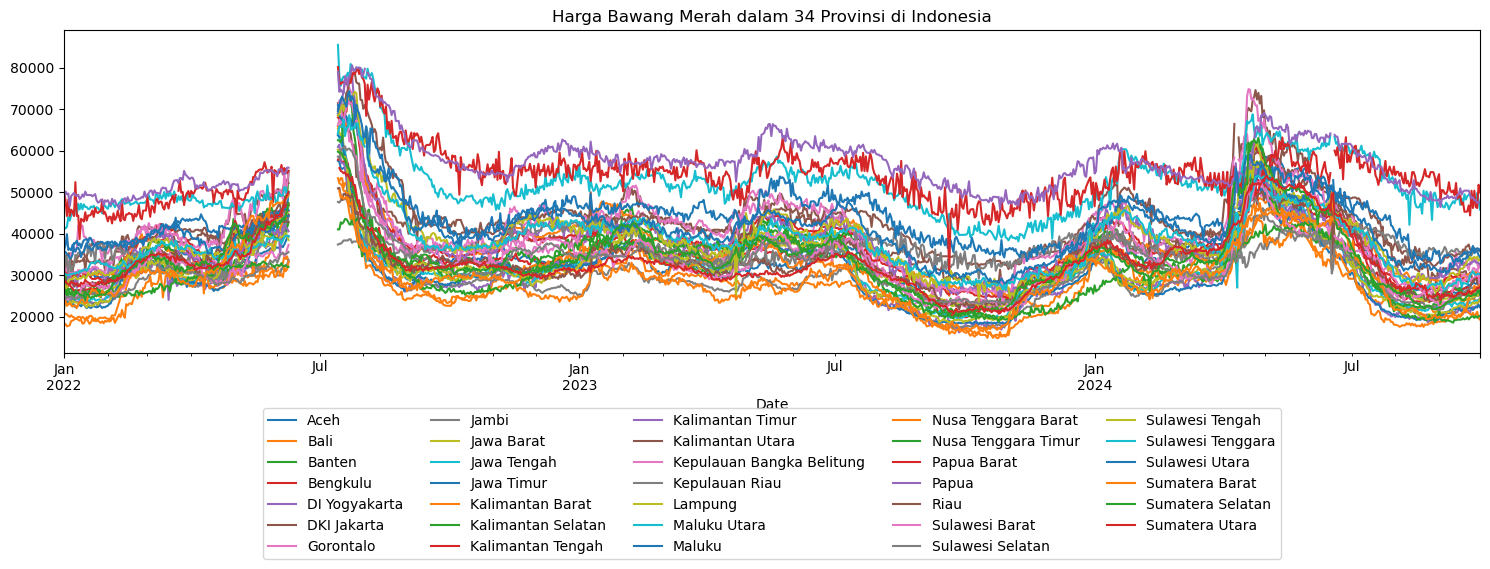

In [158]:
df.plot(figsize=(15, 6))
plt.title('Harga Bawang Merah dalam 34 Provinsi di Indonesia')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=5)
plt.tight_layout()
plt.show()

**Insight:**

Berdasarkan visualisasi yang kita lihat, harga bawang merah memiliki missing data pada Juli 2023. Sehingga kita akan coba melakukan sedikit pendekatan dengan melakukan interpolasi data untuk mengisi kekosongan data ini.

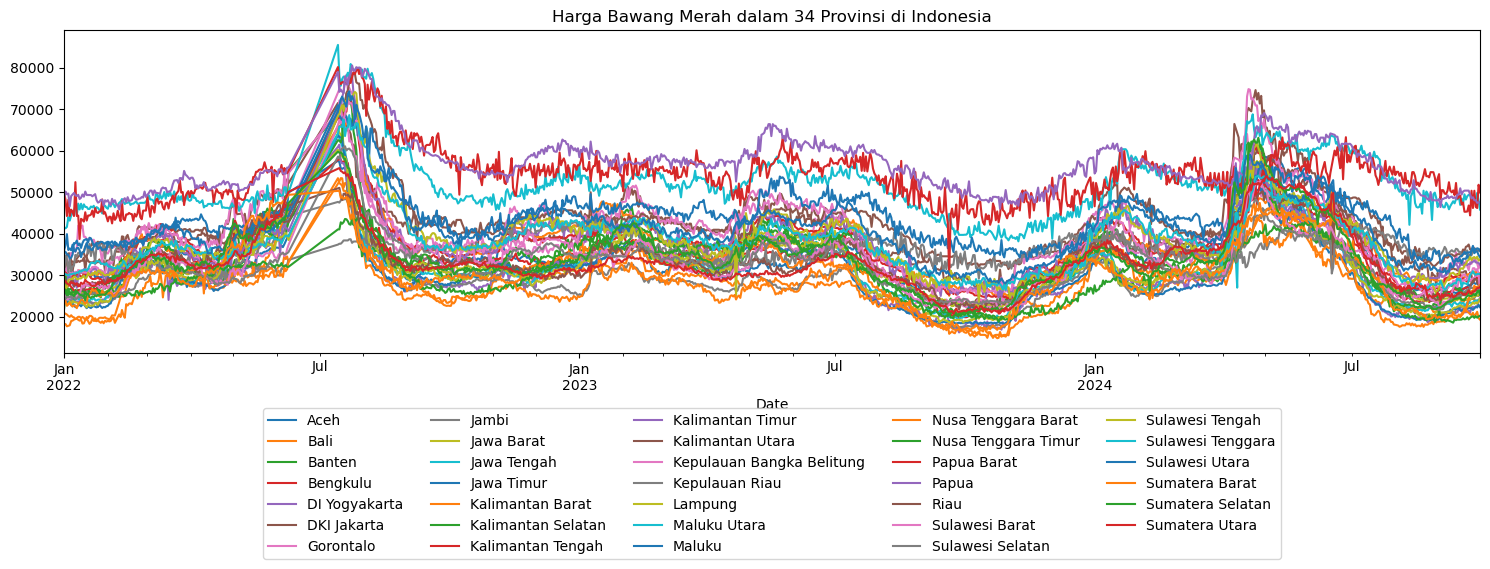

In [159]:
df.interpolate(method='linear', inplace=True)
df.plot(figsize=(15, 6))
plt.title('Harga Bawang Merah dalam 34 Provinsi di Indonesia')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=5)
plt.tight_layout()
plt.show()

Sekarang, coba kita rapikan visualisasinya dengan memperkecil range tanggal kita. Misal, dalam tahun waktu seminggu, kira-kira bagaimana fluktuasi harga bahan pangannya.

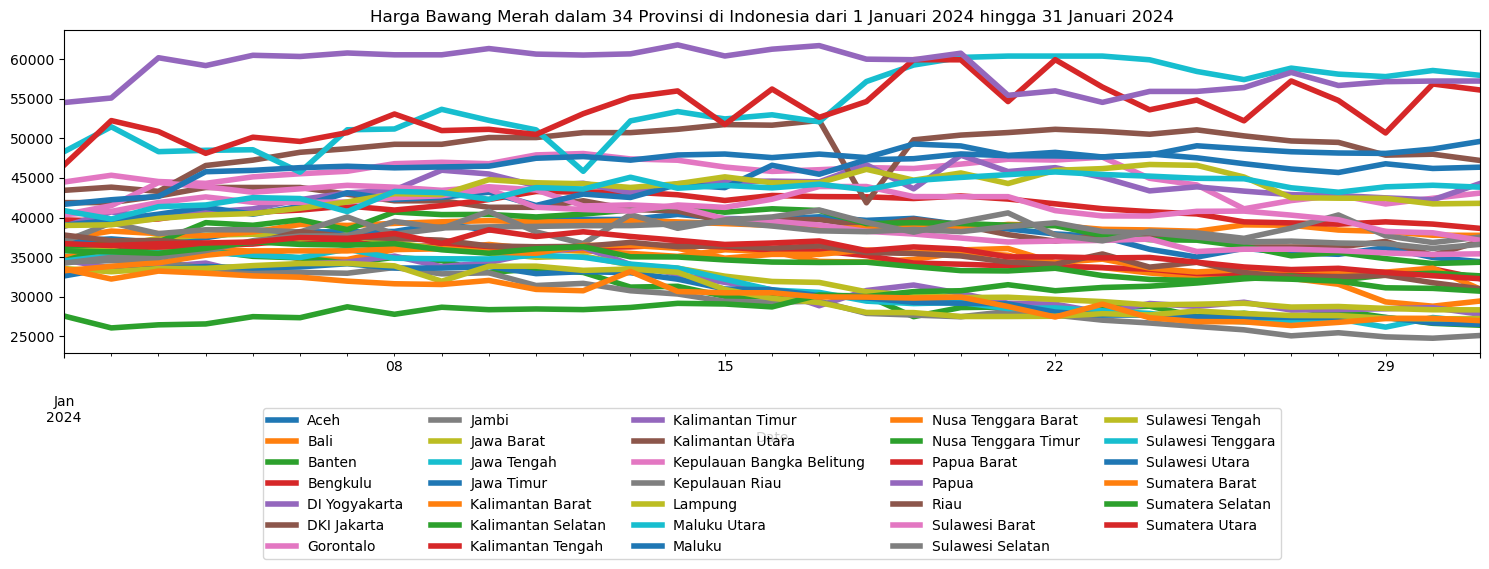

In [160]:
df_2024 = df[(df.index >= '2024-01-01') & (df.index <= '2024-01-31')]
df_2024.plot(figsize=(15, 6), lw = 4)
plt.title('Harga Bawang Merah dalam 34 Provinsi di Indonesia dari 1 Januari 2024 hingga 31 Januari 2024')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=5)
plt.tight_layout()
plt.show()

- **Feature Creation**: menambahkan kolom tambahan

Notes: fungsi ini akan dijalankan setelah proses `train_test_split`

In [161]:
def create_features(df):
    """
    Create time series features from datetime index
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    return df

<Figure size 1500x600 with 0 Axes>

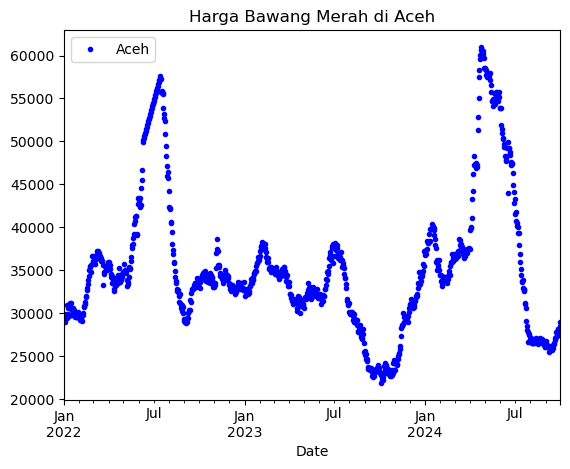

In [162]:
# Take 'Aceh' data only for training only
df_aceh = df[['Aceh']]

plt.figure(figsize=(15, 6))
df_aceh.plot(style='.', 
             color='blue', 
             title='Harga Bawang Merah di Aceh')
plt.show()

### 4. Train/Test Split

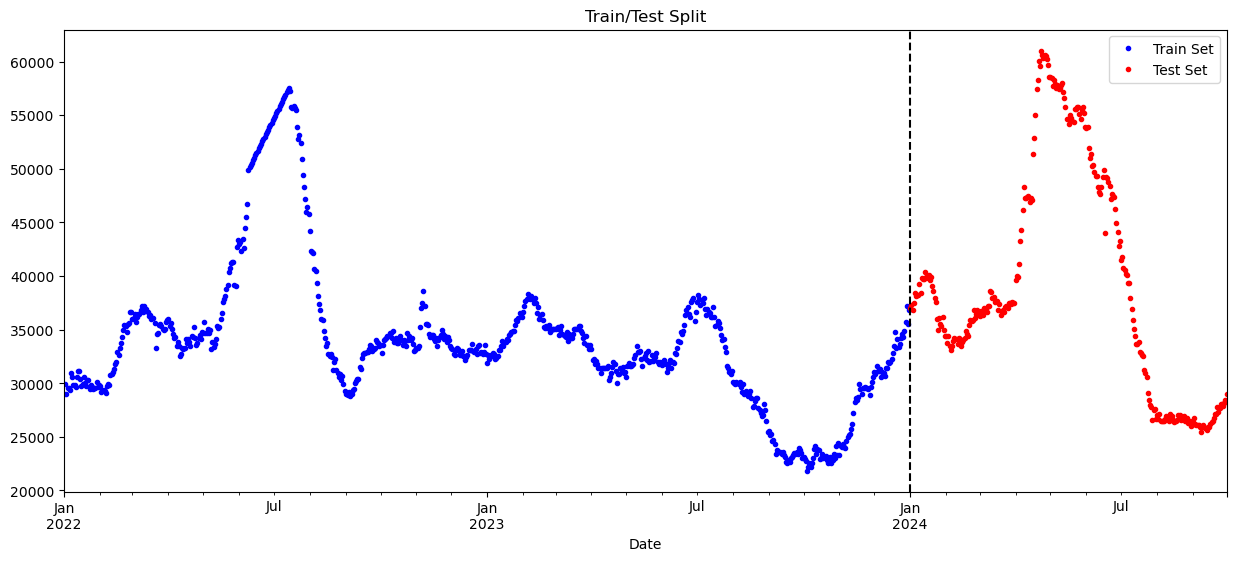

In [163]:
train_aceh = df_aceh.loc[df.index < '2024-01-01']
test_aceh = df_aceh.loc[df.index >= '2024-01-01']

fig, ax = plt.subplots(figsize=(15, 6))
train_aceh.plot(ax=ax, color='blue', style='.', lw=2)
test_aceh.plot(ax=ax, color='red', style='.', lw=2)
plt.title('Train/Test Split')
ax.axvline('01-01-2024', color='black', linestyle='--')
ax.legend(['Train Set', 'Test Set'])
plt.show()

### 5. **Features Engineering**: Memahami target relationship

In [164]:
# Sebelum itu, kita akan menambahkan fitur-fitur waktu ke dalam data
df_aceh = create_features(df_aceh)
df_aceh.head()

,Aceh,hour,dayofweek,quarter,month,year,dayofyear
Date,,,,,,,
2022-01-01,28970.0,0,5,1,1,2022,1
2022-01-02,29900.0,0,6,1,1,2022,2
2022-01-03,28970.0,0,0,1,1,2022,3
2022-01-04,29600.0,0,1,1,1,2022,4
2022-01-05,29540.0,0,2,1,1,2022,5


- **Visualize features**

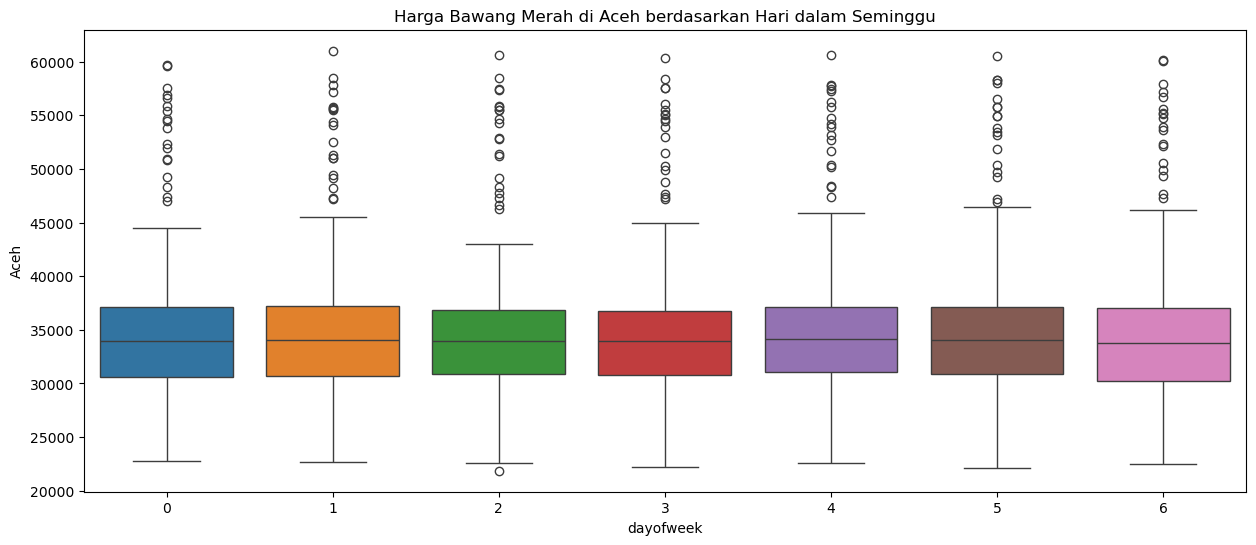

In [165]:
plt.figure(figsize=(15, 6))
sns.boxplot(data=df_aceh, x='dayofweek', y='Aceh', palette=color_pal)
plt.title('Harga Bawang Merah di Aceh berdasarkan Hari dalam Seminggu')
plt.show()

**Insight**: Dari sini kita bisa menyimpulkan bahwa peningkatan harga dalam 1 minggu cenderung sangat sedikit atau mungkin bisa dibilang tidak ada sama sekali.

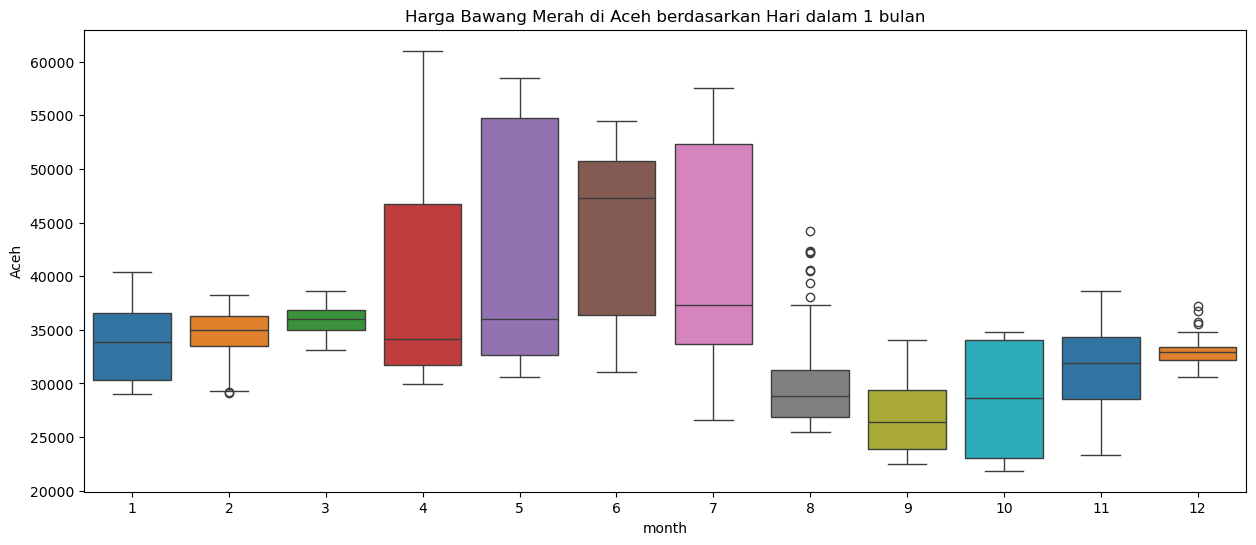

In [166]:
plt.figure(figsize=(15, 6))
sns.boxplot(data=df_aceh, x='month', y='Aceh', palette=color_pal)
plt.title('Harga Bawang Merah di Aceh berdasarkan Hari dalam 1 bulan')
plt.show()

**Insight**: Sementara dalam hitungan bulan, kita bisa melihat tingkatan-tingkatan yang terjadi, yang membuat grafik dari time series ini berupa **Seasonal**

### 6. Modelling

- 6.1 Data Splitting

In [167]:
train_aceh = create_features(train_aceh)
test_aceh = create_features(test_aceh)

features = ['dayofweek', 'quarter', 'month', 'year', 'dayofyear']
target = 'Aceh'

# Reassign X_train, X_test, y_train, y_test
X_train = train_aceh[features]
y_train = train_aceh[target]
X_test = test_aceh[features]
y_test = test_aceh[target]

- 6.2 Modelling

- **XGBoost Model Parameter:**
    - n_estimators: Banyaknya pohon yang akan dia buat.
    - early_stopping_rounds: Total epoch yang akan dia hentikan ketika model sudah mulai overfit.
    - learning_rate: kecepatan model belajar `(semakin cepat, maka semakin cepat model belajar namun semakin gampang pula dia lupa dengan pola-pola yang sudah dia pelajari)`

In [168]:
reg = xgb.XGBRegressor(n_estimators=1000,
                       early_stopping_rounds=50,
                       learning_rate=0.001)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

[0]	validation_0-rmse:6785.16475	validation_1-rmse:11741.91664
[100]	validation_0-rmse:6173.25019	validation_1-rmse:11712.69546
[200]	validation_0-rmse:5617.56351	validation_1-rmse:11699.02837
[300]	validation_0-rmse:5114.08026	validation_1-rmse:11695.20640
[376]	validation_0-rmse:4766.55577	validation_1-rmse:11696.00060


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.001, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

- 6.3 Feature Importances: Mengetahui fitur apa yang sebenarnya paling berpengaruh terhadap data.

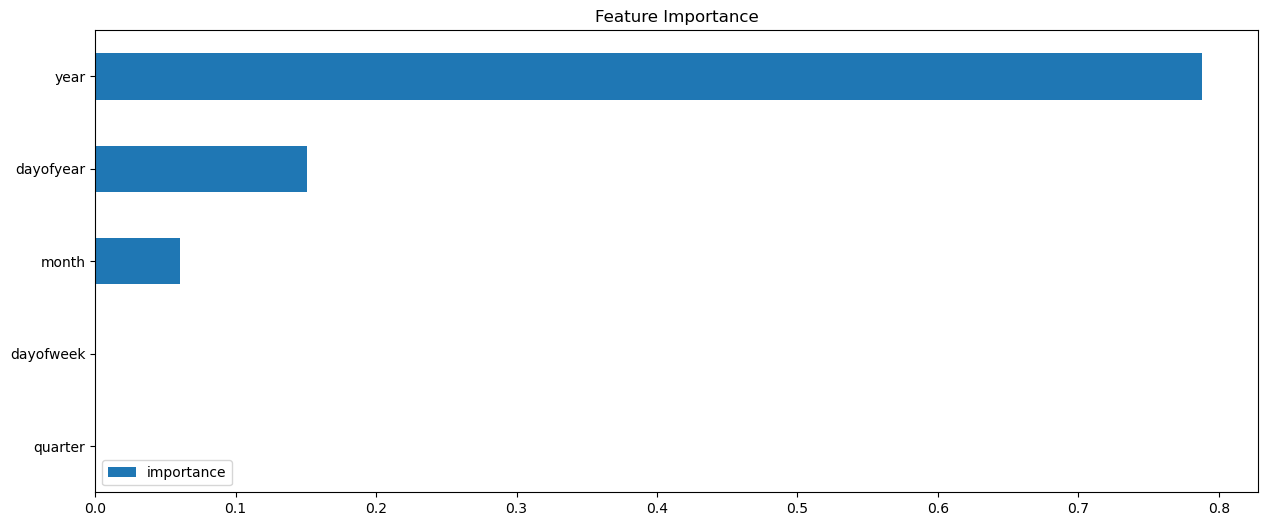

In [169]:
fi = pd.DataFrame(data=reg.feature_importances_,
                  index=reg.feature_names_in_,
                  columns=['importance'])

fi.sort_values('importance').plot(kind='barh', figsize=(15, 6))
plt.title('Feature Importance')
plt.show()

### 7. Evaluation

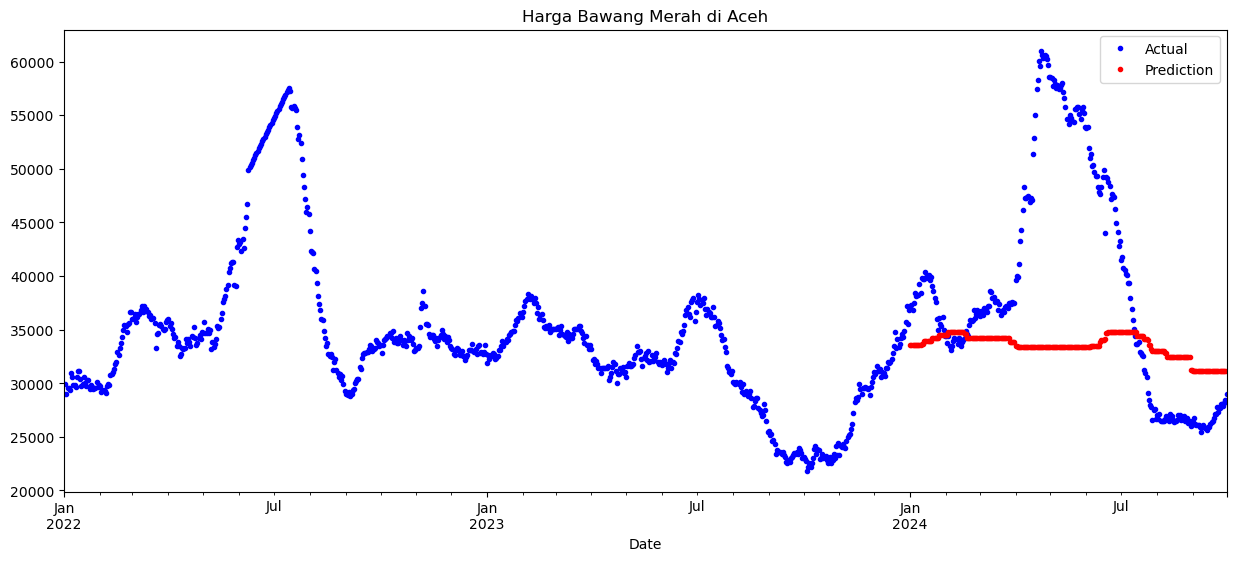

In [170]:
test_aceh['prediction'] = reg.predict(X_test)

df_aceh = df_aceh.merge(test_aceh[['prediction']], how='left', left_index=True, right_index=True)

plt.figure(figsize=(15, 6))
df_aceh['Aceh'].plot(color='blue', lw=2, style='.') # Actual
df_aceh['prediction'].plot(color='red', lw=2, style='.') # Prediction
plt.title('Harga Bawang Merah di Aceh')
plt.legend(['Actual', 'Prediction'])
plt.show()

In [173]:
mape_aceh_score = mape(test_aceh['Aceh'], test_aceh['prediction'])
print(f'MAPE Score: {mape_aceh_score.round(2)}')

MAPE Score: 0.19
